In [1]:
# Import the ncessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from fredapi import Fred

In [2]:
# Initialize the FRED API with your key
YOUR_API_KEY = '134f245798509e9960f514386bba6b38'
fred = Fred(api_key=YOUR_API_KEY)  # Replace my APIKEY with "YOUR_API_KEY"

In [3]:
# FRED series IDs for Treasury yields (adjust as needed)
series_ids = {
    '3MO': 'TB3MS',  # 3-Month Treasury Bill
    '6MO': 'TB6MS',  # 6-Month Treasury Bill
    '1YR': 'DGS1',   # 1-Year Treasury Constant Maturity
    '2YR': 'DGS2',   # 2-Year Treasury Constant Maturity
    '3YR': 'DGS3',   # 3-Year Treasury Constant Maturity
    '5YR': 'DGS5',   # 5-Year Treasury Constant Maturity
    '10YR': 'DGS10',  # 10-Year Treasury Constant Maturity
    '20YR': 'DGS20',  # 20-Year Treasury Constant Maturity
    '30YR': 'DGS30'  # 30-Year Treasury Constant Maturity
}

In [4]:
# Fetch data and store in a dictionary
yield_data = {}
for maturity, series_id in series_ids.items():
    data = fred.get_series(series_id)
    if not data.empty:
        yield_data[maturity] = data.iloc[-1]
    else:
        yield_data[maturity] = np.nan

In [5]:
# Remove any nan values.
yields_clean = {k: v for k, v in yield_data.items() if not np.isnan(v)}

In [6]:
# Create a DataFrame from the cleaned dictionary.
# Create a series from the dictionary, and then create a dataframe from that series.
yields_series = pd.Series(yields_clean)
yields_df = pd.DataFrame(yields_series, columns=['Yield'])

# Transpose the dataframe, and rename the columns.
yields_df = yields_df.T
yields_df.columns = ['3 Month', '6 Month', '1 Year', '2 Year', '3 Year', '5 Year', '10 Year', '20 Year', '30 Year']

In [7]:
# Get the index of the series that was fetched from fred.
index = data.index[-1]
yields_df.index = [index]

yields_df.head()

,3 Month,6 Month,1 Year,2 Year,3 Year,5 Year,10 Year,20 Year,30 Year
2025-03-13,4.22,4.19,4.03,3.94,3.93,4.02,4.27,4.63,4.59


In [8]:
# Convert to numpy arrays
maturities = np.array([float(m.split()[0]) / 12 if 'Month' in m else float(m.split()[0]) for m in yields_df.columns])
yields = np.array(yields_df.values[0]) / 100  # access the first row of values, and convert to decimal.

In [9]:
# Nelson-Siegel function
def nelson_siegel(t, beta0, beta1, beta2, lamb):
    return beta0 + beta1 * ((1 - np.exp(-lamb * t)) / (lamb * t)) + beta2 * \
        (((1 - np.exp(-lamb * t)) / (lamb * t)) - np.exp(-lamb * t))

In [10]:
# This line uses the 'curve_fit' function from the 'scipy.optimize' library to fit 
# the Nelson-Siegel model to the provided data.
popt, pcov = curve_fit(nelson_siegel, maturities, yields, \
                       p0=[0.07, -0.02, -0.01, 0.5], maxfev=5000)
# This line unpacks the optimized parameters from the 'popt' array 
# into individual variables for easier access.
beta0_fit, beta1_fit, beta2_fit, lambda_fit = popt

In [11]:
# Fit line for Nelson-Siegel model fucntion
fitted_yields_ns = nelson_siegel(maturities, *popt)

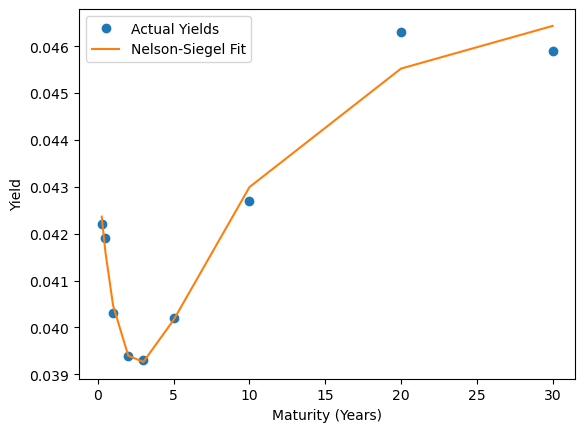

In [12]:
# Plotting the Nelson-Siegel model
plt.plot(maturities, yields, 'o', label='Actual Yields')
plt.plot(maturities, fitted_yields_ns, '-', label='Nelson-Siegel Fit')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [13]:
# Print details of fit
print(f"Beta0: {beta0_fit}, Beta1: {beta1_fit}, Beta2: {beta2_fit}, Lambda: {lambda_fit}")

Beta0: 0.04825353554879388, Beta1: -0.004957347539950099, Beta2: -0.021742548495769197, Lambda: 0.48846271339680253


In [14]:
# d. Fit a Cubic-Spline model.
cs = CubicSpline(maturities, yields)
fitted_yields_cs = cs(maturities)

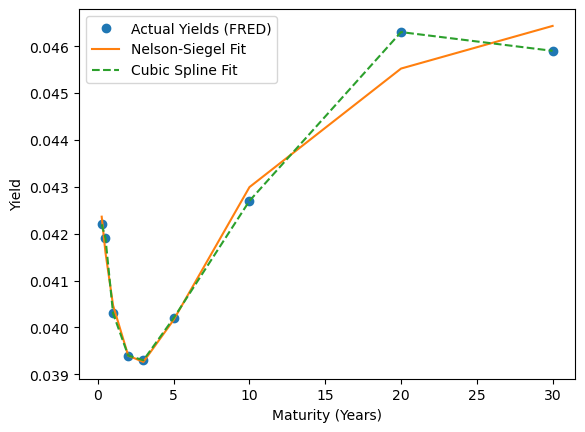

In [15]:
# Plotting
plt.plot(maturities, yields, 'o', label='Actual Yields (FRED)')
plt.plot(maturities, fitted_yields_ns, '-', label='Nelson-Siegel Fit')
plt.plot(maturities, fitted_yields_cs, '--', label='Cubic Spline Fit')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [16]:
print(f"Nelson-Siegel Parameters: Beta0: {beta0_fit}, Beta1: {beta1_fit}, Beta2: {beta2_fit}, Lambda: {lambda_fit}")

Nelson-Siegel Parameters: Beta0: 0.04825353554879388, Beta1: -0.004957347539950099, Beta2: -0.021742548495769197, Lambda: 0.48846271339680253


In [17]:
# e. Compare the models in terms of 1) fit and 2) interpretation.
print("\nModel Comparison:")
print("1) Fit:")
print("   - Cubic Spline: Likely provides a closer fit to the data points due to interpolation.")
print("   - Nelson-Siegel: Smooths the data, may deviate slightly but provides a theoretically grounded curve.")

print("\n2) Interpretation:")
print("   - Nelson-Siegel:")
print(f"      - Beta0 (Long-term level): {beta0_fit}")
print(f"      - Beta1 (Short-term level): {beta1_fit}")
print(f"      - Beta2 (Curvature): {beta2_fit}")
print(f"      - Lambda (Decay rate): {lambda_fit}")
print("   - Cubic Spline:")
print("      - Parameters are coefficients of piecewise cubic polynomials, lacking direct economic interpretations.")


Model Comparison:
1) Fit:
   - Cubic Spline: Likely provides a closer fit to the data points due to interpolation.
   - Nelson-Siegel: Smooths the data, may deviate slightly but provides a theoretically grounded curve.

2) Interpretation:
   - Nelson-Siegel:
      - Beta0 (Long-term level): 0.04825353554879388
      - Beta1 (Short-term level): -0.004957347539950099
      - Beta2 (Curvature): -0.021742548495769197
      - Lambda (Decay rate): 0.48846271339680253
   - Cubic Spline:
      - Parameters are coefficients of piecewise cubic polynomials, lacking direct economic interpretations.


In [18]:
# f. Be sure to specify at the levels of model parameters (ex. Alpha1).
print("\nParameter Interpretation:")
print("   - Nelson-Siegel:")
print("      - Beta0: Represents the long-term level of the yield curve.")
print("      - Beta1: Represents the short-term level of the yield curve.")
print("      - Beta2: Represents the curvature of the yield curve.")
print("      - Lambda: Controls the decay rate of the short-term and medium-term factors.")
print("   - Cubic Spline:")
print("      - The 'cs' object contains the coefficients of the cubic polynomials, but they are not as readily interpretable.")


Parameter Interpretation:
   - Nelson-Siegel:
      - Beta0: Represents the long-term level of the yield curve.
      - Beta1: Represents the short-term level of the yield curve.
      - Beta2: Represents the curvature of the yield curve.
      - Lambda: Controls the decay rate of the short-term and medium-term factors.
   - Cubic Spline:
      - The 'cs' object contains the coefficients of the cubic polynomials, but they are not as readily interpretable.
